# Citi-Bike Project
## Model
**Goal:** for each station (for each hour of the day) we want to calculate the optimal number of docks so that a customer will be able to find an empty spot 95% of the time.<br>
To calculate this, we will model the problem using an Eralng loss system where $P_m$ is the probability of finding the station full.  The formula for $P_m$ is given by:<br><br>
$min: m$<br>
$s.t.:\;P_m \leq.05$<br>
$where\;\; P_m = \frac{(\frac{\lambda}{\mu})^m/m!}{\sum_{i=0}^m(\frac{\lambda}{\mu})^i/i!}$
$Integer:\; m$<br>

**Estimation from data** In order to use this model we will need to estimate lambda (the arrival rate) and mu (the service rate).  We do this from data by simply counting the amount or arrivals/departures for an hour -- i.e. Moday from 8:00 am to 9:00 am there were 10 arrivals and 30 departures for dock A.  Then we take the average for these times over the most recent month.

In [1]:
import pandas as pd
citi_month = pd.read_csv("201502-citibike-tripdata.csv")
print(citi_month.head())
station_df = pd.DataFrame({'station': citi_month['start station id'],'lat': citi_month['start station latitude'],'long':citi_month['start station longitude']}).drop_duplicates(['station'])


   tripduration      starttime       stoptime  start station id  \
0           801  2/1/2015 0:00  2/1/2015 0:14               521   
1           379  2/1/2015 0:00  2/1/2015 0:07               497   
2          2474  2/1/2015 0:01  2/1/2015 0:42               281   
3           818  2/1/2015 0:01  2/1/2015 0:15              2004   
4           544  2/1/2015 0:01  2/1/2015 0:10               323   

                  start station name  start station latitude  \
0                    8 Ave & W 31 St               40.750450   
1                 E 17 St & Broadway               40.737050   
2  Grand Army Plaza & Central Park S               40.764397   
3                  6 Ave & Broome St               40.724399   
4        Lawrence St & Willoughby St               40.692362   

   start station longitude  end station id               end station name  \
0               -73.994811             423                W 54 St & 9 Ave   
1               -73.990093             504                

## Clustering
**A deflated arrival rate** We were worried that true arrival rates would be deflated because some customers are going to the location and finding it already full. To reduce this arrival rate deflation, we are modeling on a cluster basis -- we are using the arrival rate and service rates of a cluster of locations.

In [2]:
#Cluster the 328 unique stations using station_df lat and long columns
from scipy.cluster.vq import whiten, kmeans2

#want about 4 locations per cluster
clusters = len(station_df.station) // 4 #82 clusters
w = whiten(station_df[['lat','long']]) #standardize features
centroid, label = kmeans2(station_df[['lat','long']],clusters) 
station_df['label'] = label

#Save the cluster labels per station
station_df.to_csv('cluster_labels.csv')

/Users/aslakey/anaconda/lib/python3.5/site-packages/scipy/cluster/vq.py:659: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


Number of clusters 72
max number of stations per cluster 64    12
29    11
15    10
1     10
79     9
Name: label, dtype: int64


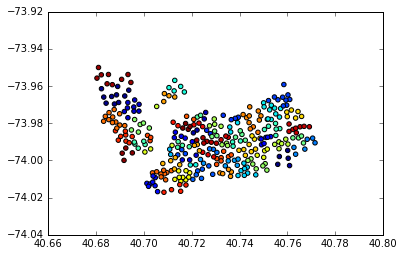

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#how many clusters/how many per cluster?
print("Number of clusters",len(pd.value_counts(station_df.label)))
print("max number of stations per cluster",pd.value_counts(station_df.label).head()) #ok most clusters have less then 7 stations.  Some have up to 16 though

#visualize the clusters
plt.scatter(station_df.lat, station_df.long, c=station_df.label)
plt.show()

## Calculating Arrival and Departure Rates

Merge Cluster output with monthly citibike data.  MLE for cluster arrival rate, $\lambda$, is the average hourly count of arrivals.  MLE for cluster service rate, $\mu$, is also the average hourly count, but this time for departures.  Thus the mean service time = $1/\mu$

In [4]:
start_df = citi_month.merge(station_df[['station','label']], left_on='start station id', right_on='station', how='outer')
full_df = start_df.merge(station_df[['station','label']], left_on='end station id', right_on='station', how='outer',suffixes=['_start',"_end"])
full_df.keys()
#release some memory 
lst = [citi_month, start_df]
del lst 
full_df.keys()

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'station_start', 'label_start', 'station_end',
       'label_end'],
      dtype='object')

In [5]:
import datetime
#create hours and days of the week
full_df['starttime'] = pd.to_datetime(full_df['starttime'],infer_datetime_format=True)
full_df['stoptime'] = pd.to_datetime(full_df['stoptime'],infer_datetime_format=True)
full_df['start_date'] = full_df['starttime'].dt.date
full_df['start_day'] = full_df['starttime'].dt.dayofweek
full_df['start_hour'] = full_df['starttime'].dt.hour
full_df['end_date'] = full_df['stoptime'].dt.date
full_df['end_day'] = full_df['stoptime'].dt.dayofweek
full_df['end_hour'] = full_df['stoptime'].dt.hour
#select hours 7 through 20
full_df = full_df.loc[(full_df.start_hour>6)&(full_df.start_hour<21)&(full_df.end_hour<21)]

#Now groupby's to calculate rates
#rate = (count(cluster,day,hour).date) / unique((cluster,day,hour).date)
service_df = full_df.groupby(['label_start','start_day','start_hour']).start_date.count()/full_df.groupby(['label_start','start_day','start_hour']).start_date.nunique()
arrival_df = full_df.groupby(['label_end','end_day','end_hour']).end_date.count()/full_df.groupby(['label_end','end_day','end_hour']).end_date.nunique()

In [6]:
#for each label, for each day of the week, for each hour we have a service and arrival rate
arrival_df = arrival_df.to_frame()
service_df = service_df.to_frame()
#service_rate.keys() #of so this is slightly confusing, but now we have what we want.  A multi-level indexed data frame
#servcice_rate[label][day][hour]

In [7]:
#Merge service and arrival data frames
service_df.index.levels[0].name = "cluster"
service_df.index.levels[1].name = 'day'
service_df.index.levels[2].name = 'hour'
arrival_df.index.levels[0].name = 'cluster'
arrival_df.index.levels[1].name = 'day'
arrival_df.index.levels[2].name = 'hour'
cluster_rates = pd.merge(service_df, arrival_df, left_index=True, right_index=True, how='outer')

cluster_rates.rename(columns={"start_date": "ServiceRate", "end_date": "ArrivalRate"}, inplace=True)
#*ASSUMPTION* That if there are any NA values, at least one person will come 
cluster_rates.fillna(value=1, inplace = True) 
cluster_rates['rho'] = cluster_rates.ArrivalRate/cluster_rates.ServiceRate
cluster_rates

ServiceRate  ArrivalRate       rho
cluster day hour                                    
0       0   7        4.500000     2.750000  0.611111
            8        6.750000     2.666667  0.395062
            9        4.750000     3.666667  0.771930
            10       2.500000     1.000000  0.400000
            11       2.500000     3.333333  1.333333
            12       3.000000     2.750000  0.916667
            13       3.666667     1.500000  0.409091
            14       3.333333     3.250000  0.975000
            15       3.000000     4.666667  1.555556
            16       4.250000     7.333333  1.725490
            17       8.000000     7.750000  0.968750
            18       5.000000     8.750000  1.750000
            19       4.750000     8.000000  1.684211
            20       1.666667     6.250000  3.750000
        1   7        4.666667     3.500000  0.750000
            8       13.000000     4.500000  0.346154
            9        7.000000     5.000000  0.714286
            10       2.666667     3.000000  1.125000
            11       4.000000     3.333333  0.833333
            12       3.333333     3.666667  1.100000
            13       3.500000     4.750000  1.357143
            14       6.250000     4.500000  0.720000
            15       7.250000     4.000000  0.551724
            16       6.000000     6.750000  1.125000
            17       7.000000    12.250000  1.750000
            18       7.750000    15.750000  2.032258
            19       5.750000    14.500000  2.521739
            20       2.250000    10.500000  4.666667
        2   7       13.250000     8.250000  0.622642
            8       17.250000     6.000000  0.347826
...                       ...          ...       ...
81      4   19       2.500000     5.500000  2.200000
            20       2.666667     3.250000  1.218750
        5   7        1.000000     1.000000  1.000000
            8        1.333333     1.000000  0.750000
            9        5.250000     2.500000  0.476190
            10       7.750000     3.333333  0.430108
            11       5.000000     3.750000  0.750000
            12       2.500000     2.500000  1.000000
            13       3.500000     2.500000  0.714286
            14       2.500000     2.000000  0.800000
            15       3.000000     3.500000  1.166667
            16       3.000000     3.666667  1.222222
            17       3.000000     6.333333  2.111111
            18       2.333333     2.500000  1.071429
            19       2.000000     3.250000  1.625000
            20       1.666667     1.000000  0.600000
        6   7        1.000000     1.000000  1.000000
            8        1.000000     1.500000  1.500000
            9        3.000000     1.500000  0.500000
            10       4.500000     1.000000  0.222222
            11       4.750000     2.666667  0.561404
            12       3.000000     3.000000  1.000000
            13       5.250000     3.250000  0.619048
            14       3.500000     3.500000  1.000000
            15       2.500000     3.500000  1.400000
            16       2.000000     3.333333  1.666667
            17       2.500000     5.000000  2.000000
            18       2.750000     5.000000  1.818182
            19       1.000000     1.250000  1.250000
            20       1.000000     1.500000  1.500000

[6956 rows x 3 columns]

In [8]:
len(cluster_rates)
cluster_rates.isnull().sum()
#for some hours rho is giving NA, we will need to fill this in somehow!

ServiceRate    0
ArrivalRate    0
rho            0
dtype: int64

## Computing Optimal Number of Docks

We are looking for the optimal number of docks at a station to service a customer who is looking to dock a bike at 98%.  Because we are modeling this as an M/G/m queue, we can use the below formulation:
$min: m$<br>
$s.t.:\;P_m \geq.02$<br>
$Integer:\; m$<br>
$where\;\; P_m = \frac{(\frac{\lambda}{\mu})^m/m!}{\sum_{i=0}^m(\frac{\lambda}{\mu})^i/i!}$

Note, that the calculation of $P_m$ quickly becomes unstable for large m, so we can revert to the recursive formulation of $P_m$. Namely, call the probability of being blocked $B(\rho,m)$ -- with utilization rate $\rho=\lambda/\mu$ and number of servers $m$ <br>
Then we can calculate $B(\rho,m)$ the following recursive formula:
$$B(\rho,m)\;=\;\frac{\rho*B(m-1,\rho)}{m+\rho*B(m-1,\rho)}$$

In [10]:
import math

def calc_sum(m,ro):
    s = 0
    for i in range(1,m+1):
        s += ((ro)**i)/math.factorial(i)
    return (s)

def Prob_m(m,ro):
    numer = ((ro)**m)/math.factorial(m)
    divis = calc_sum(m,ro)
    return(numer/divis)

def recurB(oldB,m,rho):
    numer = rho*oldB
    div = m + rho*oldB
    return(numer/div)

'''
For each row, we will first calculate P_m(1,ro).  If this is 
already less than .02, we can stop. Otherwise, we need to recurse until we
arrive at a number of docks where P_m falls below 0.02
'''
def optimal_docks(row):
    rho = row['rho']

    prob = Prob_m(1,rho)
    #only need one empty dock here
    if  prob <= .02:
        return (1)
    else:
        #might need more, recurse
        for m in range(2,1000):
            prob = recurB(prob,m,rho)
            if prob<=0.05:
                return(m)
    return

def optimal_bikes(row):
    rho = 1/row['rho']

    prob = Prob_m(1,rho)
    #only need one empty dock here
    if  prob <= .02:
        return (1)
    else:
        #might need more, recurse
        for m in range(2,1000):
            prob = recurB(prob,m,rho)
            if prob<=0.05:
                return(m)
    return

cluster_rates['optimalDocks'] = cluster_rates.apply(optimal_docks, axis=1)
cluster_rates['optimalBikes'] = cluster_rates.apply(optimal_bikes, axis=1)

In [11]:
cluster_rates.to_csv('optimal_docks.csv')
cluster_rates.describe()

,ServiceRate,ArrivalRate,rho,optimalDocks,optimalBikes
count,6956.000000,6956.000000,6956.000000,6956.000000,6956.000000
mean,6.504493,6.497903,1.144479,4.179557,4.264520
std,6.948147,7.101928,0.727683,0.997101,1.192191
min,1.000000,1.000000,0.076087,2.000000,2.000000
25%,2.333333,2.250000,0.714286,4.000000,4.000000
50%,4.500000,4.500000,1.000000,4.000000,4.000000
75%,8.250000,8.250000,1.370370,5.000000,5.000000
max,94.500000,96.500000,12.000000,17.000000,18.000000
